# Preprocessing

## Chargements des fichiers et fusion

In [39]:

#Chargement des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

In [40]:
# repertoire (relatif) des ficheirs de données
data_path = '../../Data'


In [41]:
#chargement des nomenclatures

#libelles : correspodnance valeur de la variable avec le libelle correspond
libelles = pd.read_csv('{}/libelles.csv'.format(data_path), sep=';', index_col=['colonne', 'indice'])

#variable : libelle complet pour chaque variable
variables = pd.read_csv('{}/variables.csv'.format(data_path), sep=';', index_col = ['variable'])


In [42]:
#chargement des données
annees = [str(x) for x in np.arange(2019,2023)]

carac = pd.DataFrame()
lieux = pd.DataFrame()
usagers = pd.DataFrame()
vehicules = pd.DataFrame()
for annee in annees : 
    carac = pd.concat([carac, pd.read_csv("{}/caracteristiques-{}.csv".format(data_path, annee), sep=';', dtype=object)])
    lieux = pd.concat([lieux, pd.read_csv("{}/lieux-{}.csv".format(data_path, annee), sep=';', dtype=object)])
    usagers = pd.concat([usagers, pd.read_csv("{}/usagers-{}.csv".format(data_path, annee), dtype=object,sep=';')])
    vehicules = pd.concat([vehicules, pd.read_csv("{}/vehicules-{}.csv".format(data_path, annee), sep=';', dtype=object)])


In [43]:
#correction identifiant accident
carac['Num_Acc'] = carac['Num_Acc'].fillna(carac['Accident_Id'])
carac = carac.drop('Accident_Id', axis = 1)

#jointure carac-lieux
df = pd.merge(left = carac, right = lieux, left_on = 'Num_Acc', right_on='Num_Acc')

#jointure df-vehicules
df = pd.merge(left=df, right=vehicules, left_on='Num_Acc', right_on='Num_Acc')

#jointure df-usagers
df = pd.merge(left=df, right=usagers, right_on='id_vehicule', left_on='id_vehicule')

#suppression des identifiants
df = df.drop(['Num_Acc_x', 'id_vehicule', 'num_veh_x', 'Num_Acc_y','num_veh_y', 'id_usager'], axis = 1)

## Corrections des données

In [44]:
#recodage dess données manquantes en nan
df = df.replace({
    '-1':np.nan,
    -1:np.nan,
    ' -1':np.nan,
    '#ERREUR':np.nan
})


In [45]:
#secu  : un champ binaire par équipement
for i in range(1,10) :
    df['secu_'+str(i)] = ((df['secu1']==i) | (df['secu2']==i) | (df['secu3']==i))*1

df = df.drop(['secu1','secu2','secu3'], axis = 1)

In [46]:
pd.DataFrame({'column_name': df.columns,'percent_missing': df.isnull().sum() * 100 / len(df)}).sort_values('percent_missing', ascending=False).head(5)


,column_name,percent_missing
lartpc,lartpc,99.781052
occutc,occutc,98.742973
larrout,larrout,95.380649
etatp,etatp,92.323476
v2,v2,91.998494


In [47]:
#elimination des colonnes avec plus de 25% de valeurs manquantes
df = df.dropna(thresh=len(df)*3/4, axis = 1)

In [48]:
#p
#suppression des lignes sans variable d'Interet
df = df.dropna(subset=['grav'])

In [49]:
#p
# suppression de l'adresse qui ne sert à rien
df = df.drop('adr', axis = 1)

In [50]:
#p
#suppression des variables de dénomination des voies ininterprétables
df = df.drop(['voie','v1'], axis = 1)

In [51]:
df.isna().sum(axis = 1).sum()/len(df)

0.1438342434716055

In [52]:
#p
#suppression des lignes ayant au mojns une valeur nulle (#14%)
df = df.dropna(how = 'any', axis=0)

In [53]:
#restent 442989 lignes
df.shape

(442989, 47)

In [54]:
#p
#conversion des latitudes et longitudes
df['lat']= df['lat'].str.replace(',','.').astype('float')
df['long']= df['long'].str.replace(',','.').astype('float')


In [55]:
#
#on ajoute un créneau horaire
df['hh'] = df['hrmn'].str[:2]

df = df.drop('hrmn', axis = 1)

In [56]:
#p
#conversion en entier
df['hh'] = df['hh'].astype('int')

In [57]:
#p
df['mois'] = df['mois'].astype(int)

In [58]:
#p
#on ajoute une variablme binaire indiquant semaine ou weekend
df['weekend']=(pd.to_datetime(dict(day=df['jour'], month=df['mois'].astype(int), year=df['an'])).dt.weekday>=5)*1

In [59]:
#calcul de l'age des usagers dans l'année de l'accident
df['age'] = df['an'].astype(int) - df['an_nais'].astype(int)

df = df.drop('an_nais', axis = 1)

In [60]:
#p
#suppression des jours et années
df = df.drop(['jour','an'], axis = 1)

In [61]:
#p
# suppression des varaible de localisation (on utilsaera la géolocalisation) et des varaibles diffficilement interprétabes
df = df.drop(['pr','pr1', 'senc', 'dep'], axis = 1)

In [62]:
df.shape

(442989, 42)

In [63]:
# Conversion des variables catégorielles en entiers
df[['lum', 'int', 'atm', 'col',  'circ', 'vosp', 'prof',
       'plan', 'surf', 'infra', 'situ', 'vma', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'place', 'grav', 'sexe', 'trajet','nbv']] = df[['lum', 'int', 'atm', 'col',  'circ', 'vosp', 'prof',
       'plan', 'surf', 'infra', 'situ', 'vma', 'catv', 'obs', 'obsm', 'choc',
       'manv', 'motor', 'place', 'grav', 'sexe', 'trajet','nbv']].astype('int')

In [64]:
#recodage de la gravité : indice croissant
"""
Av => apr => label
1 => 0 => Indemme
4 => 1 => Blessé léger
3 => 2 => Blessé hospitalisé
2 => 3 => Tué
"""

df['grav']=df['grav'].replace({1:0})
df['grav']=df['grav'].replace({4:1})

df['grav']=df['grav'].replace({3:5})
df['grav']=df['grav'].replace({2:3})
df['grav']=df['grav'].replace({5:2})

## Géolocalisation

In [65]:
#corrections coordonnées martinique
# coordonnées inversées
idx = (df['com'].str[0:3] == '972' ) &  (df['long'].between(14,15) & (df['lat'].between(-62,-61) ))
df.loc[idx, ['lat','long']] = df.loc[idx, ['long','lat']].values

# longitude 16 <=> 61
idx = (df['com'].str[0:3] == '972' ) & ( (df['long']==16 ))
df.loc[idx, 'long'] = 61

#longitude positive <=> négative
idx = (df['com'].str[0:3] == '972' ) & ( (df['long']> 0 ))
df.loc[idx, 'long'] = -df['long']

#coordonnées saint pierre erronées : on remplace par le mode
m_lat = df.loc[df['com']=='97213','lat'].mode()
m_long = df.loc[df['com']=='97213','long'].mode()

idx = (df['com'] == '97213' ) & (df['long'] == -1.407665)

df.loc[idx,'lat'] = m_lat[0]
df.loc[idx, 'long'] = m_long[0] 

# correction de la longitude erronée pour la guadeloupe
idx = (df['com'].str[0:3] == '971' ) & ( (df['long']> 0 ))
df.loc[idx, 'long'] = - df['long']


In [66]:
#suppression du code commune
df = df.drop('com', axis = 1)

## Statistiques

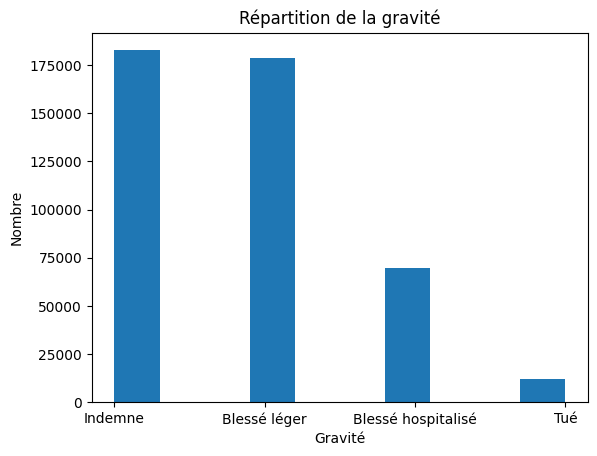

In [67]:
gravite = ['Indemne','Blessé léger', 'Blessé hospitalisé', 'Tué',]

df['grav'].astype('str').sort_values().hist(grid=False)
plt.title('Répartition de la gravité')
plt.ylabel('Nombre')
plt.xlabel('Gravité')
plt.xticks(ticks=['0','1','2','3'],labels=gravite);

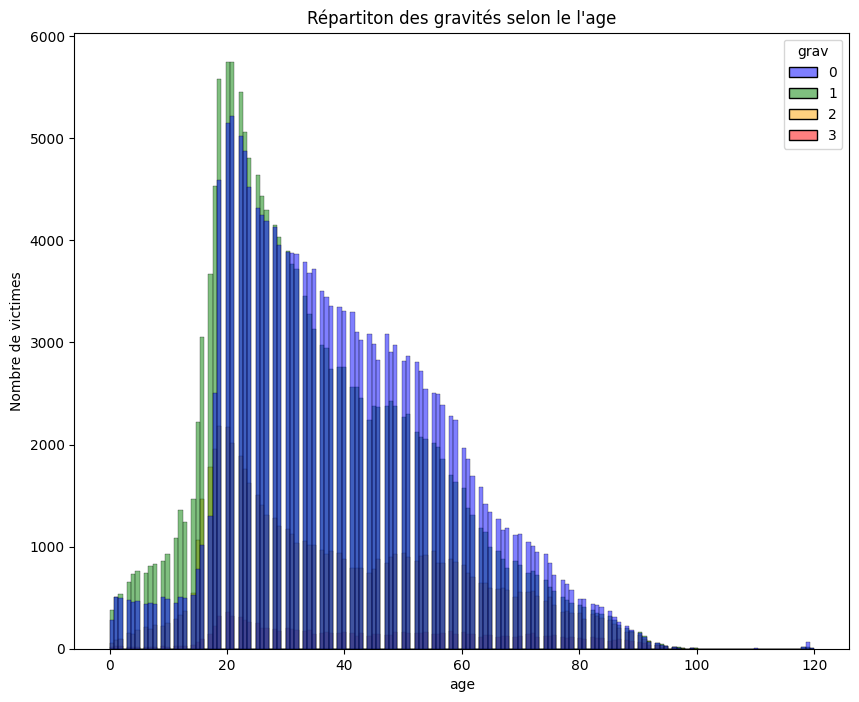

In [68]:
sns.color_palette("Paired")
palette = ['blue','green', 'orange','red']
        
g = sns.histplot(data=df, x='age',  hue='grav', palette=palette)
g.figure.set_size_inches(10,8)
plt.ylabel('Nombre de victimes')
plt.title('Répartiton des gravités selon le l\'age');

In [81]:
#création de classes d'ages à la place de la variable numérique age
bins = [0,9,17,24,44,64,999]
labels=[0,1,2,3,4,5]
df['classe_age'] = pd.cut(df['age'], bins=bins, labels=labels, include_lowest=True)

In [89]:
df = df.drop('age', axis = 1)

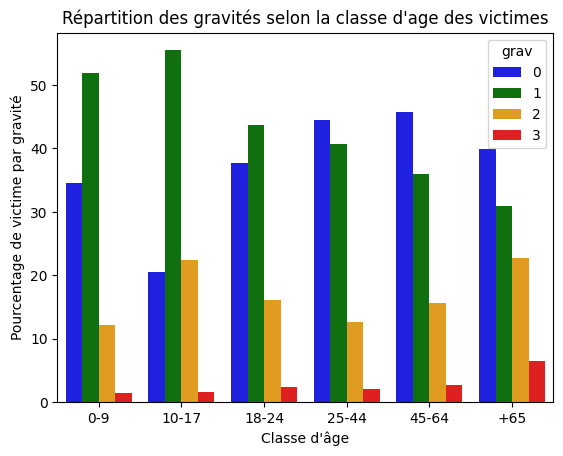

In [90]:
df_age = (df.groupby(['classe_age','grav'],observed=True).size()*100 / df.groupby('classe_age', observed=False).size()).reset_index(name='percent')
sns.barplot(data = df_age, x='classe_age', y='percent', hue='grav', palette = palette)
plt.xlabel('Classe d\'âge')
plt.ylabel('Pourcentage de victime par gravité')
plt.title('Répartition des gravités selon la classe d\'age des victimes');
plt.xticks(ticks = range(0,6),labels = ['0-9','10-17','18-24','25-44','45-64','+65']);

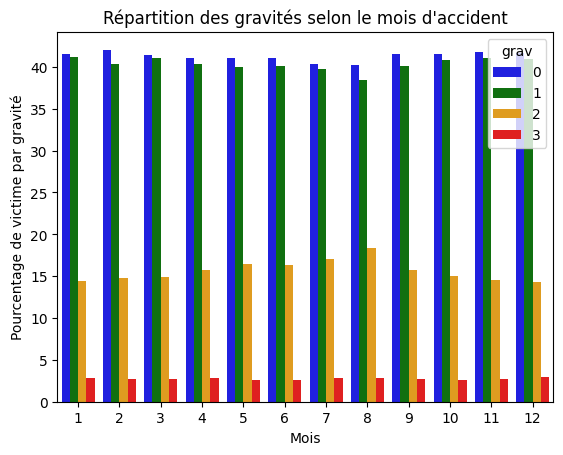

In [94]:
df_mois = (df.groupby(['mois','grav'],observed=True).size()*100 / df.groupby('mois', observed=False).size()).reset_index(name='percent')
sns.barplot(data = df_mois, x='mois', y='percent', hue='grav', palette = palette)
plt.xlabel('Mois')
plt.ylabel('Pourcentage de victime par gravité')
plt.title('Répartition des gravités selon le mois d\'accident');
#plt.xticks(ticks = range(0,6),labels = ['0-9','10-17','18-24','25-44','45-64','+65']);

In [95]:
# dernières conversion
df[['mois','agg','catr','catu','classe_age']] = df[['mois','agg','catr','catu','classe_age']].astype(int)

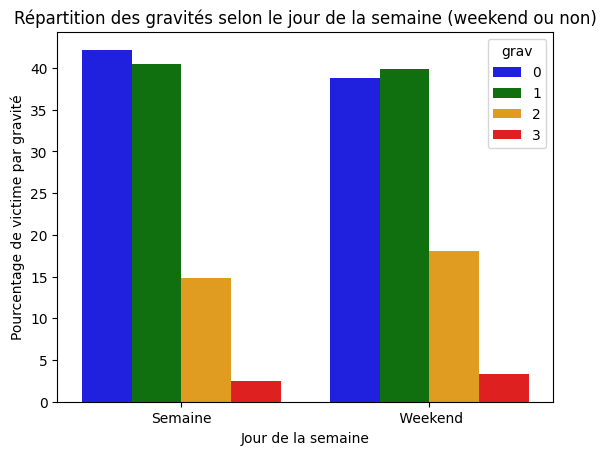

In [97]:
df_we = (df.groupby(['weekend','grav']).size()*100 / df.groupby('weekend').size()).reset_index(name='percent')

sns.color_palette("Paired")
palette = ['blue','green', 'orange','red']
sns.barplot(data = df_we, x='weekend', y='percent', hue='grav', palette = palette)
plt.xlabel('Jour de la semaine')
plt.ylabel('Pourcentage de victime par gravité')
plt.title('Répartition des gravités selon le jour de la semaine (weekend ou non)');
plt.xticks(ticks = [0,1],labels = ['Semaine',' Weekend']);


In [98]:
#sauvegarde du fichier
df.to_csv('{}/accidents.zip'.format(data_path), index = False, compression=dict(method='zip', archive_name='accidents.csv'))